# 0. Standard imports

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append('/Users/khalilouardini/Desktop/projects/scVI/scvi')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***import ete3 Tree***

In [75]:
from ete3 import Tree

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/tree_test.txt"
#tree = Tree(tree_name, 1)

tree = Tree()
tree.populate(60)

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)
    if not n.is_leaf():
        n.name = str(i)

***Prune tree***

In [77]:
#for i, n in enumerate(tree.traverse()):
#    print(i, n.name)

#split_node = tree.search_nodes(name='2|2|2|2|2|0|2|2|2|0|2|2|0|2|0|2|2|2|0|2|2|2|2|0|0|0|0|0|0')[0]
#sub_leaves = [n.name for n in split_node.get_leaves()]
#tree.prune(sub_leaves)

In [78]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE

# Utils
from utils.data_util import get_leaves, get_internal
from utils.metrics import ks_pvalue, accuracy_imputation, correlations, knn_purity, knn_purity_stratified
from utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density
from utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene, training_dashboard
from utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations (Poisson GLM)

In [79]:
d = 10
g = 1000
vis = False
leaves_only = False
var = 1.0

#glm = Poisson_GLM(tree_name, g, d, vis, leaves_only, var)
glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)

glm.simulate_latent()

Generate gene expression count data

In [80]:
glm.simulate_ge()
# Quality Control (i.e Gene Filtering)
#glm.gene_qc()
glm.X.shape

(119, 1000)

GLM parameters

In [81]:
glm.W.shape, glm.beta.shape

((10, 1000), (1000,))

***Binomial thinning***

In [82]:
print("Proportion of dropouts: {}".format(np.mean(glm.X == 0)))
#glm.binomial_thinning(p=0.01)
#print("Proportion of dropouts after Binomial thinning: {}".format(np.mean(glm.X == 0)))

Proportion of dropouts: 0.43504201680672266


Get the data and the indexes at the leaves

In [83]:
# Latent vectors
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((60, 1000), (60, 1000), (59, 1000), (59, 1000), (60, 10))

***Visualizing the data***

***Tree***

In [84]:
plot_one_gene(tree=tree,
             X=glm.X,
             g=0,
             node_sizes=[800 for i in range(glm.X.shape[0])],
             var='latent',
             size=1000,
             show_index=True,
             save_fig=True,
             figsize=(180, 100)
             )

***Simulated latent space***

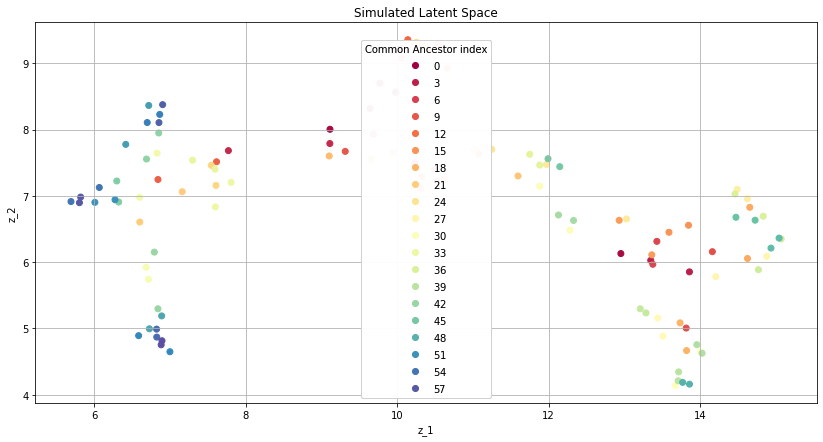

In [86]:
plot_common_ancestor(tree,
                     glm.z,
                     embedding='umap',
                     give_labels=False)

# 2. Fitting CascVI

In [209]:
import scanpy as sc

# anndata + gene and celle filtering
adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
#sc.pp.filter_genes(adata, min_counts=3)
#sc.pp.filter_cells(adata, min_counts=0)

In [210]:
scvi_dataset = AnnDatasetFromAnnData(adata)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

[2021-04-01 11:48:05,646] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-01 11:48:05,647] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-01 11:48:05,649] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-01 11:48:05,650] INFO - scvi.dataset.dataset | Downsampled from 60 to 60 cells


***Create a TreeDataset object***

In [211]:
# treeVAE
import copy

tree_bis = copy.deepcopy(tree)
cas_dataset = TreeDataset(scvi_dataset, tree=tree_bis)
cas_dataset

# No batches beacause of the message passing
use_batches = False
use_cuda = False

[2021-04-01 11:48:06,094] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-01 11:48:06,095] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-01 11:48:06,096] INFO - scvi.dataset.dataset | Keeping 1000 genes
[2021-04-01 11:48:06,099] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-01 11:48:06,100] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-01 11:48:06,101] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-01 11:48:06,102] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-01 11:48:06,103] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-01 11:48:06,105] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-01 11:48:06,106] INFO - scvi.dataset.dataset | Downsampled from 60 to 60 cells


***Initialize model***

In [272]:
#var = 1.0
vae = TreeVAE(cas_dataset.nb_genes,
              tree = tree,
              n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent,
              n_hidden=128,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = var,
              ldvae = False
             )

***Hyperparameters***

In [273]:
n_epochs = 400
lr = 1e-3
lambda_ = 1.0

***trainer***

In [274]:
freq = 10
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    lambda_ = lambda_,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59]]
test_leaves:  []
validation leaves:  []


***Start training***

In [275]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
training:   0%|          | 0/400 [00:00<?, ?it/s]Encodings MP Likelihood: 17.415034657911917
ELBO Loss: 531431.1488979895
Encodings MP Likelihood: 17.8073622758615
ELBO Loss: 515451.33576228033
Encodings MP Likelihood: 17.947012744368298
ELBO Loss: 502294.5560449651
Encodings MP Likelihood: 17.80588549820333
ELBO Loss: 488177.79344352835
training:   1%|          | 4/400 [00:00<00:10, 36.74it/s]Encodings MP Likelihood: 18.620468959933387
ELBO Loss: 475075.9124130603
Encodings MP Likelihood: 17.979050315493716
ELBO Loss: 461821.85737702076
Encodings MP Likelihood: 18.21073816257327
ELBO Loss: 446299.36527010676
Encodings MP Likelihood: 18.345430272734752
ELBO Loss: 433312.50544033415
training:   2%|▏         | 8/400 [00:00<00:10, 36.24it/s]Encodings MP Likelihood: 18.249252449231683
ELBO Loss: 420744.17598206474
Encodings MP Likelihood: 18.34099677179246
ELBO Loss: 407093.97474096884
computing elbo
Encodings MP Likelihood: 18.320347319736232
ELBO Loss: 392582.40557976416
E

training:  23%|██▎       | 92/400 [00:02<00:09, 33.10it/s]Encodings MP Likelihood: 21.12379175377347
ELBO Loss: 86458.67249438306
Encodings MP Likelihood: 21.22405734922763
ELBO Loss: 85246.98512332169
Encodings MP Likelihood: 21.658387417043787
ELBO Loss: 84275.32253104621
Encodings MP Likelihood: 21.504785745918873
ELBO Loss: 84189.82047128156
training:  24%|██▍       | 96/400 [00:02<00:08, 33.86it/s]Encodings MP Likelihood: 21.433395126387392
ELBO Loss: 82942.97274292268
Encodings MP Likelihood: 21.588506911036575
ELBO Loss: 82473.64643827274
Encodings MP Likelihood: 21.45451069690437
ELBO Loss: 81559.69559375501
Encodings MP Likelihood: 21.07271732922243
ELBO Loss: 81959.21936926375
computing elbo
training:  25%|██▌       | 100/400 [00:02<00:08, 33.43it/s]Encodings MP Likelihood: 21.199184025451586
ELBO Loss: 80751.74509230799
Encodings MP Likelihood: 21.150669213549477
ELBO Loss: 79016.8260833511
Encodings MP Likelihood: 21.758315497610784
ELBO Loss: 78165.74261406678
Encodings MP

training:  46%|████▌     | 184/400 [00:05<00:06, 34.28it/s]Encodings MP Likelihood: 22.89703447502275
ELBO Loss: 38511.540536657165
Encodings MP Likelihood: 22.716003614132124
ELBO Loss: 39088.79029984519
Encodings MP Likelihood: 22.70420377068139
ELBO Loss: 39239.70455937237
Encodings MP Likelihood: 22.704398259916164
ELBO Loss: 38598.22338373803
training:  47%|████▋     | 188/400 [00:05<00:06, 34.57it/s]Encodings MP Likelihood: 22.907105485459642
ELBO Loss: 37770.326121637205
Encodings MP Likelihood: 22.909963154794333
ELBO Loss: 37455.253664155854
computing elbo
Encodings MP Likelihood: 23.147354525508913
ELBO Loss: 37457.978087041854
Encodings MP Likelihood: 22.71449624377019
ELBO Loss: 37591.57203330464
training:  48%|████▊     | 192/400 [00:05<00:06, 33.89it/s]Encodings MP Likelihood: 22.7603266781928
ELBO Loss: 36876.96140865389
Encodings MP Likelihood: 22.75173399824085
ELBO Loss: 36451.88232819254
Encodings MP Likelihood: 23.082891304629516
ELBO Loss: 35779.58667473138
Encodin

training:  69%|██████▉   | 276/400 [00:08<00:03, 34.47it/s]Encodings MP Likelihood: 24.229137281683602
ELBO Loss: 22846.52846851088
Encodings MP Likelihood: 23.958532504631606
ELBO Loss: 22689.412463078574
Encodings MP Likelihood: 23.993457047867125
ELBO Loss: 23265.020527097327
Encodings MP Likelihood: 23.967638308538636
ELBO Loss: 22652.889219100653
computing elbo
training:  70%|███████   | 280/400 [00:08<00:03, 32.93it/s]Encodings MP Likelihood: 24.0949527664064
ELBO Loss: 22788.936197861167
Encodings MP Likelihood: 24.303643189294238
ELBO Loss: 22381.37499675149
Encodings MP Likelihood: 24.38343196310126
ELBO Loss: 21967.026713973424
Encodings MP Likelihood: 24.314594688483567
ELBO Loss: 21474.162215938548
training:  71%|███████   | 284/400 [00:08<00:03, 32.34it/s]Encodings MP Likelihood: 24.317339565573455
ELBO Loss: 21729.987186350427
Encodings MP Likelihood: 24.04876207480974
ELBO Loss: 22191.586718280952
Encodings MP Likelihood: 23.863528416835415
ELBO Loss: 22203.193300627154


Encodings MP Likelihood: 24.87366107917467
ELBO Loss: 15976.679477443518
Encodings MP Likelihood: 25.063210190994337
ELBO Loss: 15850.550639089834
training:  92%|█████████▏| 368/400 [00:11<00:01, 30.07it/s]Encodings MP Likelihood: 25.069180309954596
ELBO Loss: 15395.703031554986
Encodings MP Likelihood: 24.76825712744744
ELBO Loss: 16497.486294648876
computing elbo
Encodings MP Likelihood: 24.661035242871943
ELBO Loss: 16611.243228878553
Encodings MP Likelihood: 24.686076073846507
ELBO Loss: 16425.68803132627
training:  93%|█████████▎| 372/400 [00:11<00:00, 29.71it/s]Encodings MP Likelihood: 25.20938007957444
ELBO Loss: 16020.570757497211
Encodings MP Likelihood: 24.811961511088985
ELBO Loss: 16141.740173855796
Encodings MP Likelihood: 25.136273376036343
ELBO Loss: 15599.618125874258
Encodings MP Likelihood: 24.926984355804407
ELBO Loss: 15970.512172516119
training:  94%|█████████▍| 376/400 [00:11<00:00, 30.35it/s]Encodings MP Likelihood: 24.728104610903536
ELBO Loss: 16250.17556223072

***Loss Functions***

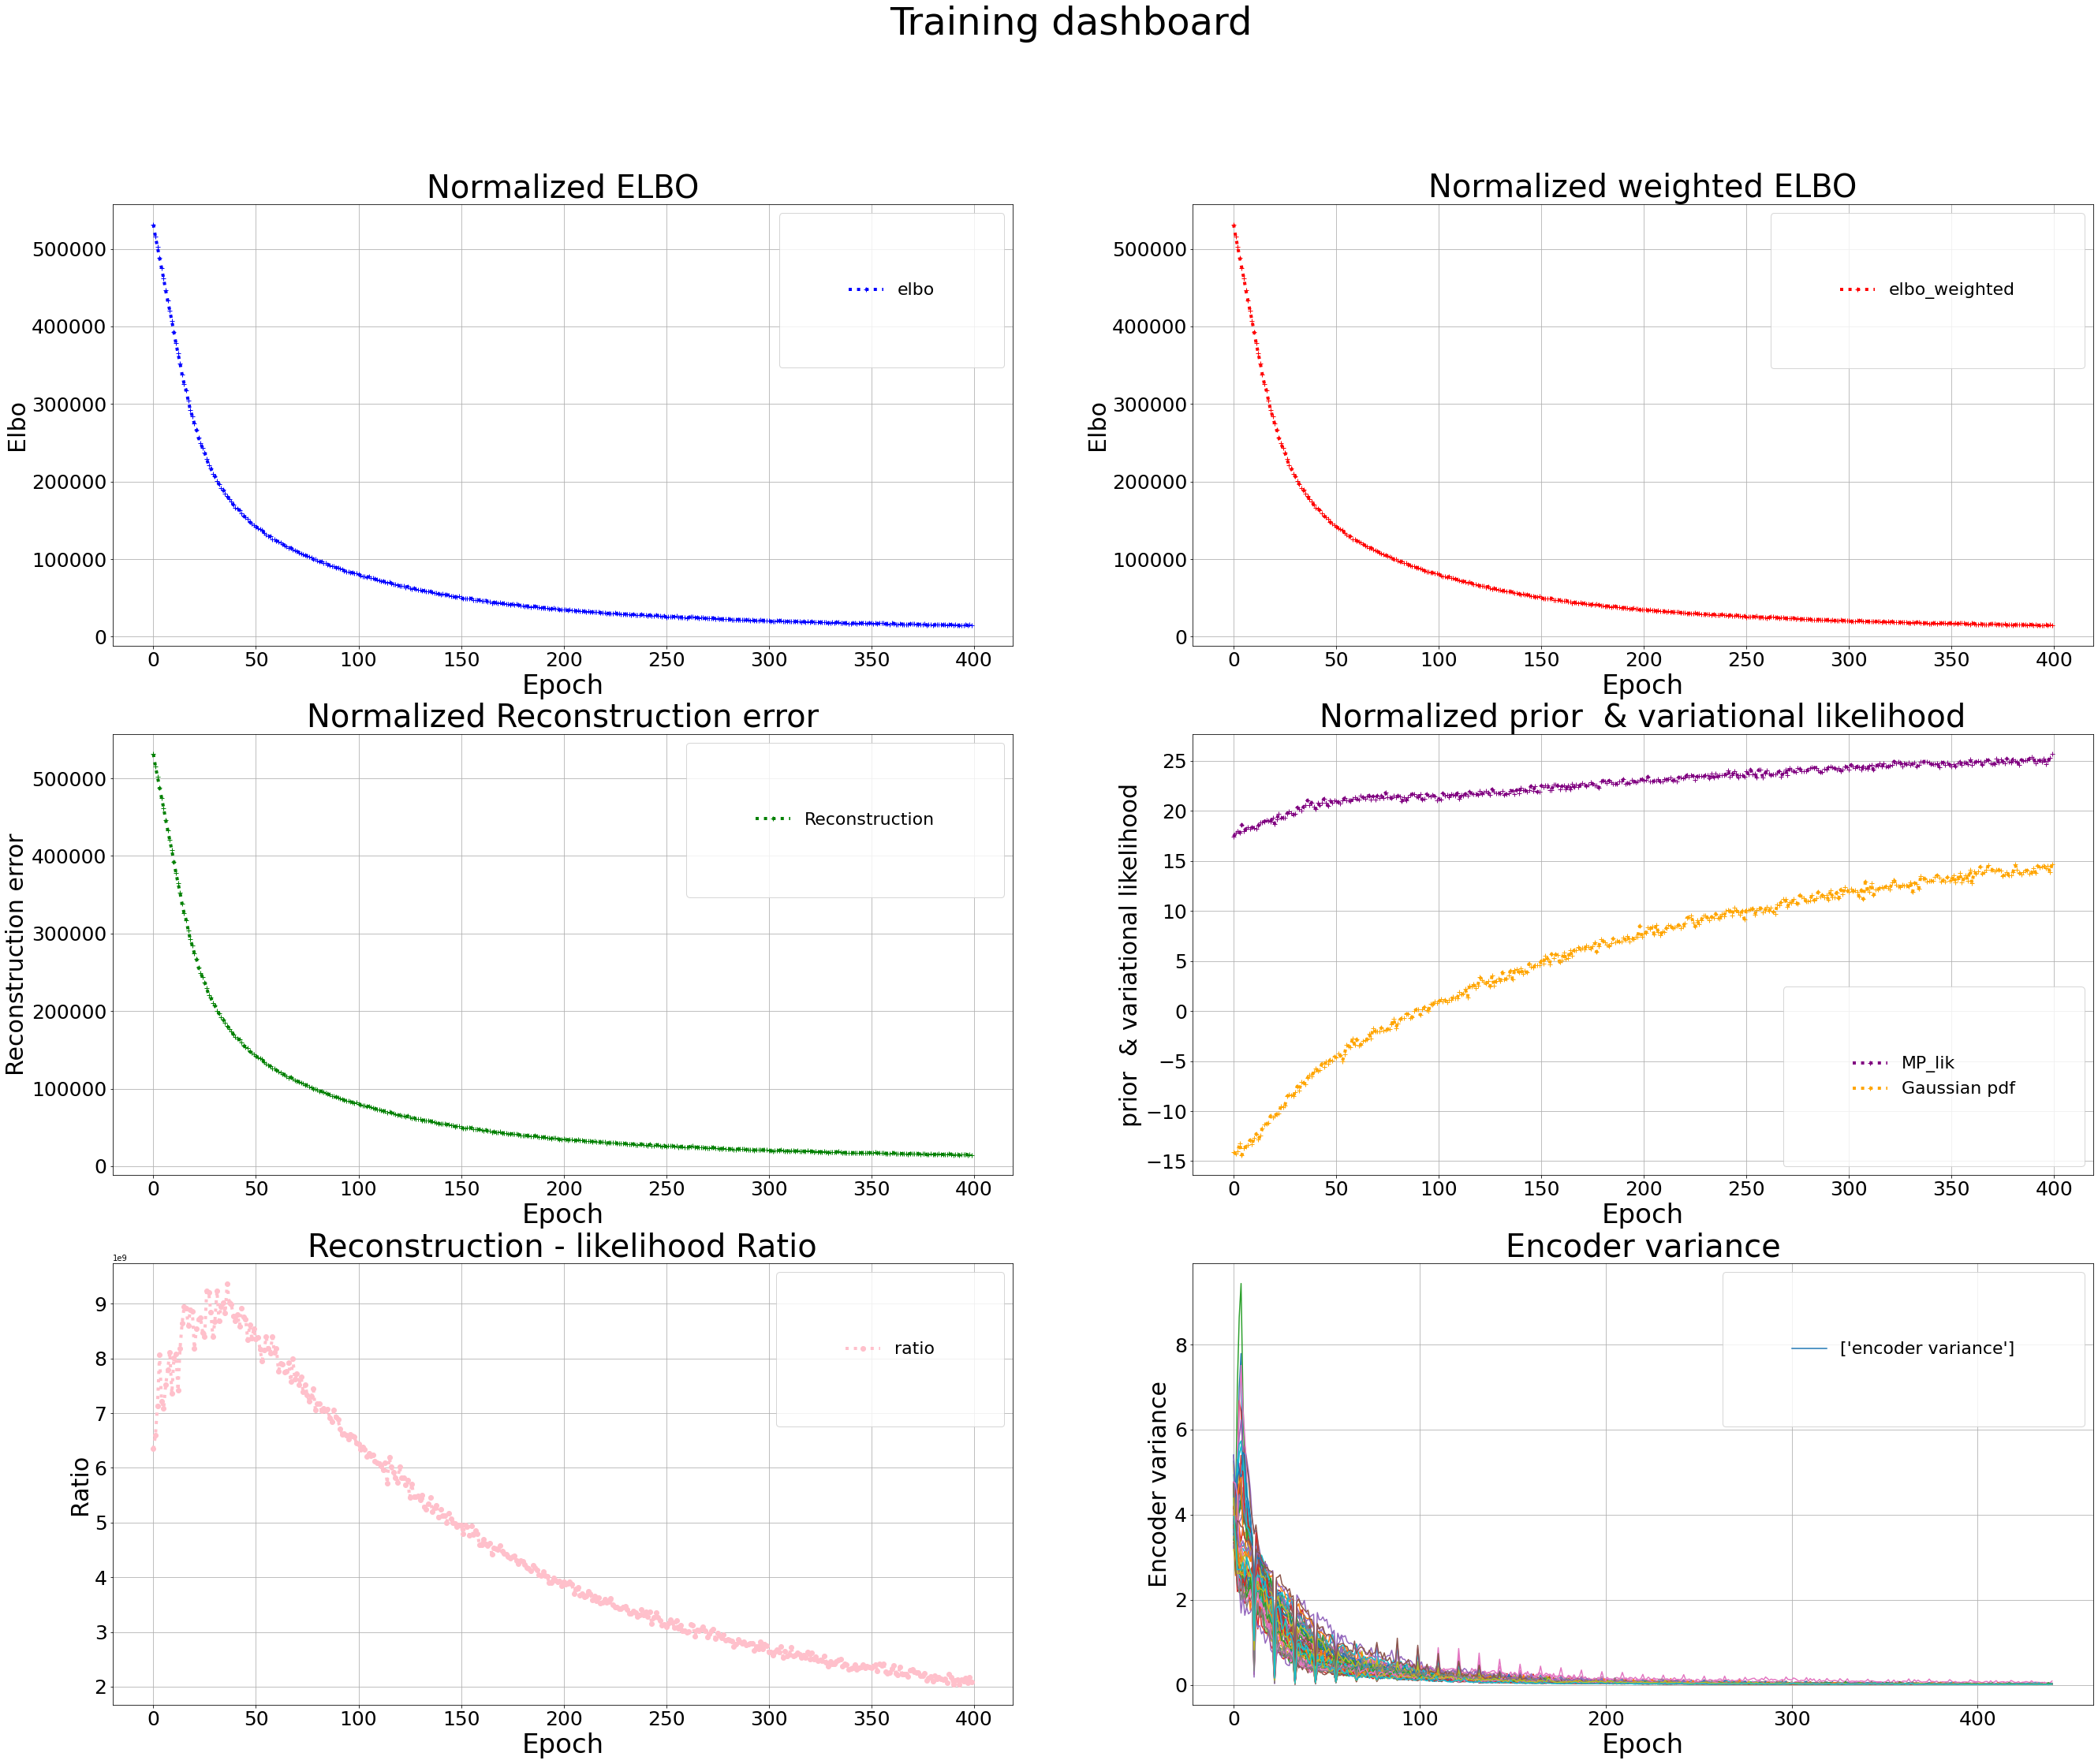

In [276]:
training_dashboard(trainer, vae.encoder_variance)

### 3. Posterior and MV imputation

In [277]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset))
                                         )

***Missing Value imputation By Posterior Predictive sampling***

In [278]:
empirical_l = np.mean(np.sum(glm.X, axis=1))

# CascVI impitations
imputed = {}
imputed_z = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l
                                                           )
        imputed_gt[n.name] = glm.X[n.index]

In [279]:
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, cas_dataset.X.shape[1])
#plot_histograms(imputed_X, "Histogram of CasscVI imputed gene expression data")

***CascVI Baseline 1 (Average of reconstructions)***

In [280]:
imputed_cascvi_1 = scvi_baseline(tree, full_posterior, True)

***CascVI Baseline 2 (Reconstruction of Averaged latent space)***

In [281]:
imputed_cascvi_2, imputed_cascvi_2_z = scvi_baseline_z(tree=tree,
                                   model=vae,
                                   posterior=full_posterior,
                                   weighted=True,
                                   n_samples_z=1,
                                   library_size=empirical_l
                                  )

# 4. Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [282]:
weighted = True
imputed_avg = avg_weighted_baseline(tree, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, tree)
#plot_histograms(avg_X,
#               'Histograms of imputed GE values with the average baseline')

***Baseline 2: (Un)weighted Average of decoded latent vectors, with scVI***

We use the same averaging of the subtrees leaves in **Baseline 1**, only this time, the gene expression data is recovered with scVI

In [223]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

[2021-04-01 11:53:46,930] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-01 11:53:46,931] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


training: 100%|██████████| 400/400 [00:04<00:00, 81.37it/s]


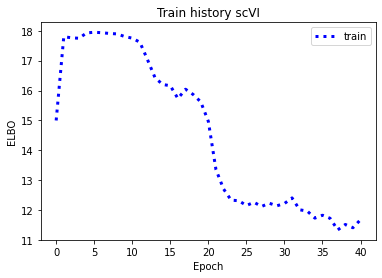

In [224]:
n_epochs = 400

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.latent)

trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=10,
                              n_epochs_kl_warmup=None)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

***scVI Baseline 1 (Average of reconstructions)***

In [225]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset
                                              )

imputed_scvi, imputed_scvi_z = scvi_baseline(tree=tree, 
                                             posterior=scvi_posterior, 
                                             weighted=True,
                                            give_latent=True,
                                            n_samples_z=1)

scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

(60, 10)

***scVI Baseline 2 (Decoded Average Latent space)***

In [226]:
library_size = np.mean(np.sum(glm.X, axis=1))
imputed_scvi_2, imputed_scvi_2_z = scvi_baseline_z(tree=tree,
                                 model=vae_scvi,
                                 posterior=scvi_posterior,
                                 weighted=True,
                                 n_samples_z=1,
                                 library_size=library_size
                                )


***CascVI Baseline 3***

In [227]:
imputed_cascvi_3 = cascvi_baseline_z(tree=tree,
                                   model=vae_scvi,
                                   latent=imputed_z,
                                   library_size=library_size
                                  )

***(Bonus) MP Imputation with scVI latent space***

In [228]:
empirical_l = library_size

# CascVI impitations
imputed_bis = {}
imputed_z_bis = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_bis[n.name], imputed_z_bis[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            other_posterior=scvi_posterior
                                                           )

# 5. Likelihood Ratio

In [283]:
cascvi_latent = full_posterior.get_latent()[0]
scvi_latent.shape, cascvi_latent.shape

((60, 10), (60, 10))

In [284]:
vae.initialize_visit()
vae.initialize_messages(scvi_posterior.get_latent()[0], cas_dataset.barcodes, scvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), scvi_latent.shape[1], False)
mp_lik_scvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of scVI encodings: ", mp_lik_scvi.item())

Likelihood of scVI encodings:  -1465.8164996977582


In [285]:
vae.initialize_visit()
vae.initialize_messages(full_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_cascvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of cascVI encodings: ", mp_lik_cascvi.item())

Likelihood of cascVI encodings:  -1486.106359630685


In [286]:
# Likelihood ratio
lambda_ = (mp_lik_cascvi - mp_lik_scvi)
print("Likelihood Ratio:", lambda_)

Likelihood Ratio: tensor(-20.2899, dtype=torch.float64)


# 6. Latent Space Analysis

***Message Passing on "ground truth" latent space***

In [287]:
from utils.baselines import construct_latent
empirical_l = library_size

# CascVI impitations
imputed_real = {}
imputed_z_real = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_real[n.name], imputed_z_real[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            known_latent=leaves_z
                                                           )
full_real_latent = construct_latent(tree, leaves_z, imputed_z_real)

#print("Real latent space")
#plot_common_ancestor(tree_bis,
#                     full_real_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )

In [288]:
mu_real = np.clip(a=np.exp(full_real_latent @ glm.W + glm.beta),
                         a_min=0,
                         a_max=5000
                  )

X_real = np.asarray(np.random.poisson(mu_real), dtype=np.float64)
internal_X_real, _, _ = get_internal(X_real, mu_real, tree)
internal_X_real.shape

(59, 1000)

***CascVI***

In [289]:
# Merge internal nodes and leaves
full_cascvi_latent = construct_latent(tree, cascvi_latent, imputed_z)


#print("CascVI latent space")
#plot_common_ancestor(tree_bis,
#                     full_cascvi_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )



In [290]:
full_cascvi_latent_2 = construct_latent(tree, cascvi_latent, imputed_cascvi_2_z)

#print("CascVI + averaging latent space")
#plot_common_ancestor(tree_bis,
#                     full_cascvi_latent_2,
#                     embedding='umap',
#                     give_labels=False
#                             )

***scVI***

In [291]:
# Merge internal nodes and leaves
full_scvi_latent = construct_latent(tree, scvi_latent, imputed_scvi_2_z)

#print("scVI latent space")
#plot_common_ancestor(tree_bis,
#                 full_scvi_latent,
#                 embedding='umap',
#                 give_labels=False
#                    )

***scVI + Message Passing***

In [292]:
# Merge internal nodes and leaves
full_scvi_latent_2 = construct_latent(tree, scvi_latent, imputed_z_bis)

#print("scVI latent space + Message passing")
#plot_common_ancestor(tree,
#                 full_scvi_latent_2,
#                 embedding='umap',
#                 give_labels=False
#                    )

In [293]:
full_scvi_latent_2.shape

(119, 10)

***k-NN purity***

Leaves only

Leaves Only


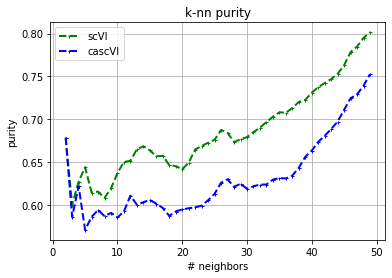

In [294]:
print("Leaves Only")
scores = knn_purity(max_neighbors=50,
              data=[leaves_z, scvi_latent, cascvi_latent],
              plot=True)

Internal nodes only

Internal nodes Only


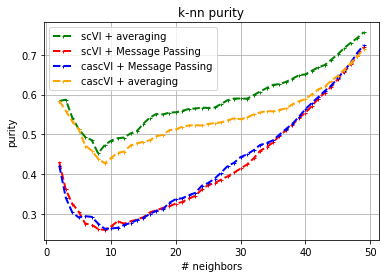

In [295]:
print("Internal nodes Only")
internal_z, internal_idx, internal_mu = get_internal(glm.z, glm.mu, tree)
internal_scvi_z, _, _ = get_internal(full_scvi_latent, glm.mu, tree)
internal_scvi_z_2, _, _ = get_internal(full_scvi_latent_2, glm.mu, tree)
internal_cascvi_z, _, _ = get_internal(full_cascvi_latent, glm.mu, tree)
internal_cascvi_z_2, _, _ = get_internal(full_cascvi_latent_2, glm.mu, tree)

scores = knn_purity(max_neighbors=50,
              data=[internal_z, internal_scvi_z, internal_scvi_z_2, internal_cascvi_z, internal_cascvi_z_2],
              plot=True
              )

Full tree

Full tree


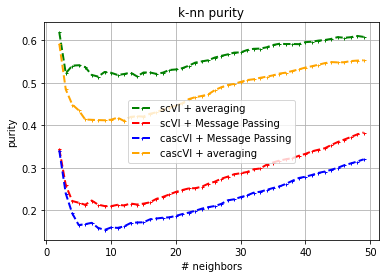

In [271]:
print("Full tree")
scores = knn_purity(max_neighbors=50,
              data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
              plot=True)

***Stratified k-NN purity***

In [ ]:
for k in [2, 5, 10, 20, 35, 50]:
    print("For {} neighbors".format(k))
    if k == 10:
        min_depth = 3
    elif k == 20:
        min_depth = 4
    elif k == 35:
        min_depth = 6
    elif k == 50:
        min_depth = 7
    else:
        min_depth = 2
    scores = knn_purity_stratified(n_neighbors=k,
                                   tree=tree,
                                   data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
                                   min_depth=min_depth,
                                   plot=True)

# 7. Variance analysis

***Empirical Variance of observed***

In [ ]:
# Get empirical variance of the encoder
qz_v_norm = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
var_dict = {}
node_sizes = []

for i, n in enumerate(tree.traverse('levelorder')):
    if not n.is_leaf():
        # if n is an internal node, we get the variance from the prior
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var_dict[n.name] = str(np.around(a=v_nu,
                             decimals=4)
                              )
        node_sizes.append(np.around(a=v_nu,
                             decimals=4)
                         )
    else:
        idx = leaves_idx.index(n.index)
        # if n is a leaf, we get the variance from the encoder
        
        # variational distribution variance
        
        # Empirical variance
        var_dict[n.name] = str(np.around(a=qz_v_norm[idx],
                                 decimals=4)
                             )
        node_sizes.append(np.around(a=qz_v_norm[idx],
                                 decimals=4) 
                         )

In [ ]:
var_dict

***Plot variance***

In [ ]:
plot_one_gene(tree=tree, 
              X=imputed_X, 
              g=0, 
              node_sizes=[int(n*10000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=True,
              save_fig=True,
              figsize=(180, 100)
             )

print("CascVI: Imputations + Variance analysis")

# 7. Evaluation

***CPM Normalization (for sample-sample correlation)***

get imputations into an array

In [296]:
internal_scvi_X = np.array([x for x in imputed_scvi.values()]).reshape(-1, glm.X.shape[1])
internal_scvi_X_2 = np.array([x for x in imputed_scvi_2.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X = np.array([x for x in imputed_cascvi_1.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_2 = np.array([x for x in imputed_cascvi_2.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_cascvi_3.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_real.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_3 = internal_X_real

internal_scvi_X.shape, internal_scvi_X_2.shape, internal_cascvi_X.shape, internal_cascvi_X_2.shape, internal_cascvi_X_3.shape

((59, 1000), (59, 1000), (59, 1000), (59, 1000), (59, 1000))

In [297]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X'] 
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_scvi_X_2 = sc.pp.normalize_total(AnnData(internal_scvi_X_2), target_sum=1e4, inplace=False)['X']
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']
norm_imputed_X = sc.pp.normalize_total(AnnData(imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_2 = sc.pp.normalize_total(AnnData(internal_cascvi_X_2), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_3 = sc.pp.normalize_total(AnnData(internal_cascvi_X_3), target_sum=1e4, inplace=False)['X']

norm_internal_X.shape

(59, 1000)

## I. Sample-Sample Correlations

***1. Sample-Sample correlation (Without Normalization)***

We will use Scipy to compute a nonparametric rank correlation between the imputed and the groundtruth profiles. The correlation is based on the Spearman Correlation Coefficient.

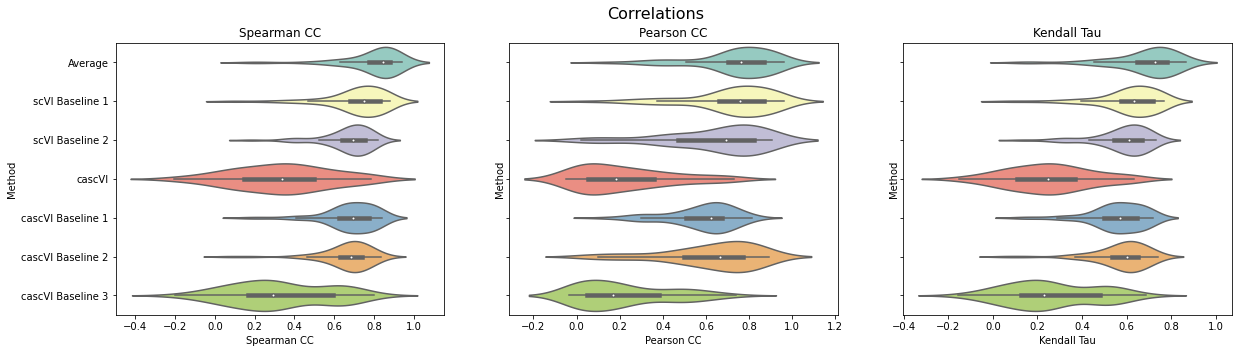

In [298]:
data = [internal_X.T, imputed_X.T, internal_avg_X.T ,internal_scvi_X.T,
        internal_scvi_X_2.T, internal_cascvi_X.T, internal_cascvi_X_2.T, internal_cascvi_X_3.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***2. Sample-Sample correlation (With ScanPy Normalization)***

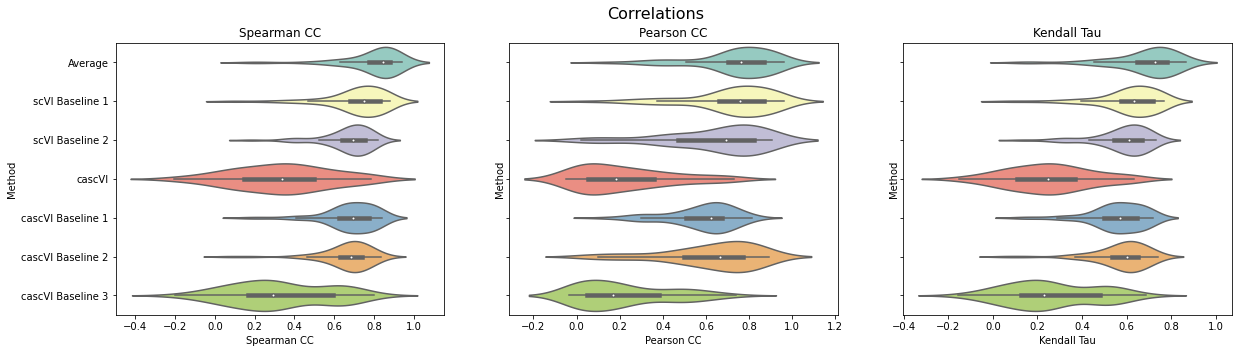

In [299]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T,
        norm_scvi_X_2.T, norm_cascvi_X.T, norm_cascvi_X_2.T, norm_cascvi_X_3.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()


## II. Gene-Gene Correlations

***1. Gene-Gene correlation (without Normalization)***

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


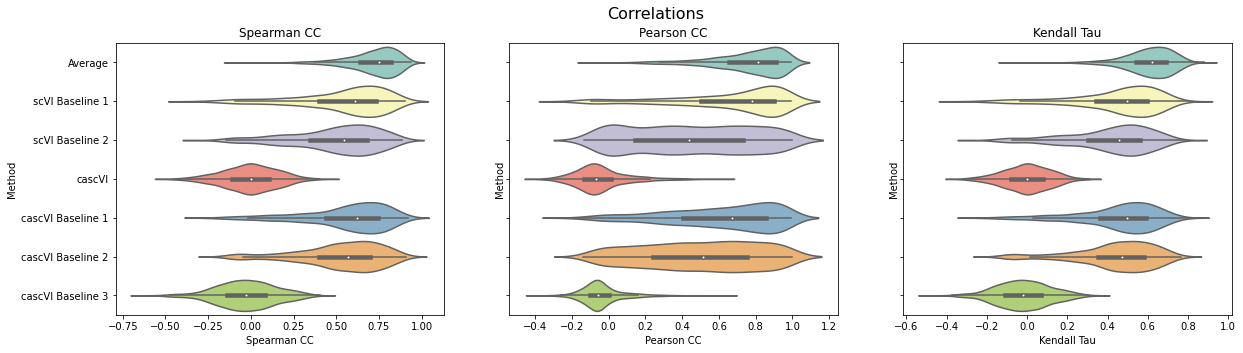

In [300]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X,
        internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2, norm_cascvi_X_3]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

***2. Gene-Gene correlation (With Normalization)***

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


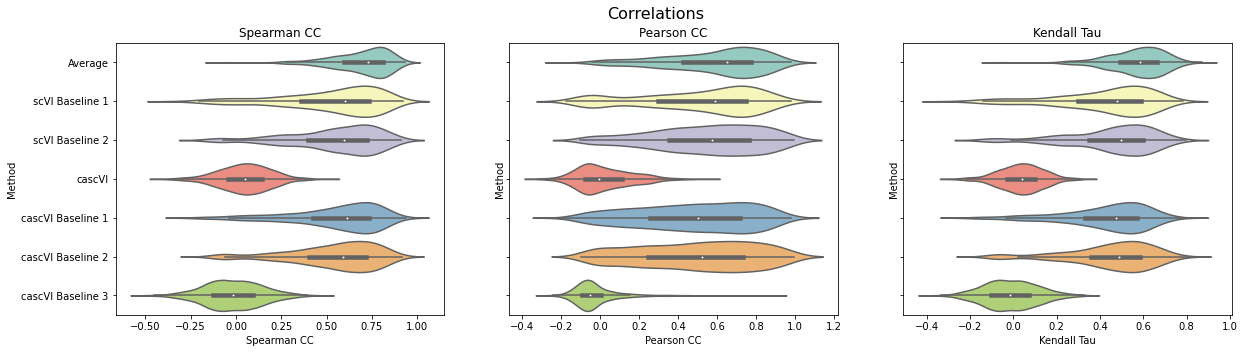

In [301]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3]

df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

***3. Gene-Gene correlation (With Rank Normalization)***

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


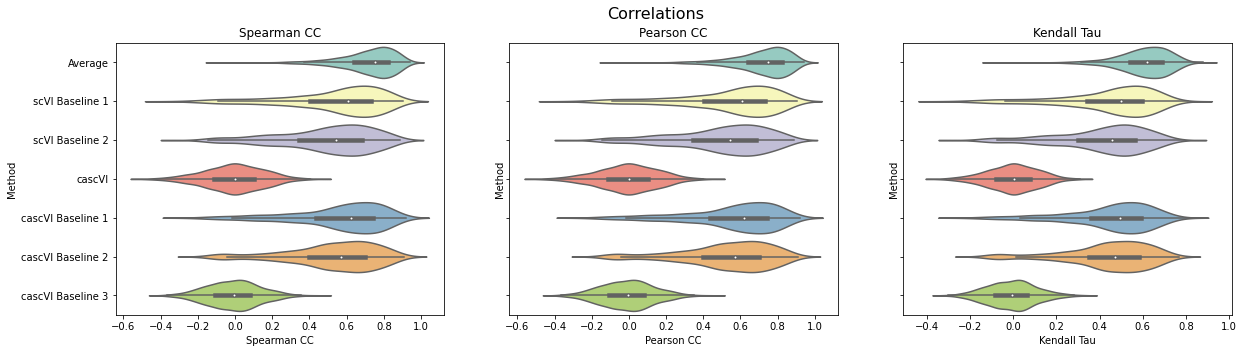

In [302]:
data = [internal_X, imputed_X, internal_avg_X ,
        internal_scvi_X, internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3
       ]

df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

***4. Gene-Gene correlation (With ScanPy + Rank Normalization)***

//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
//anaconda3/envs/berkeley/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


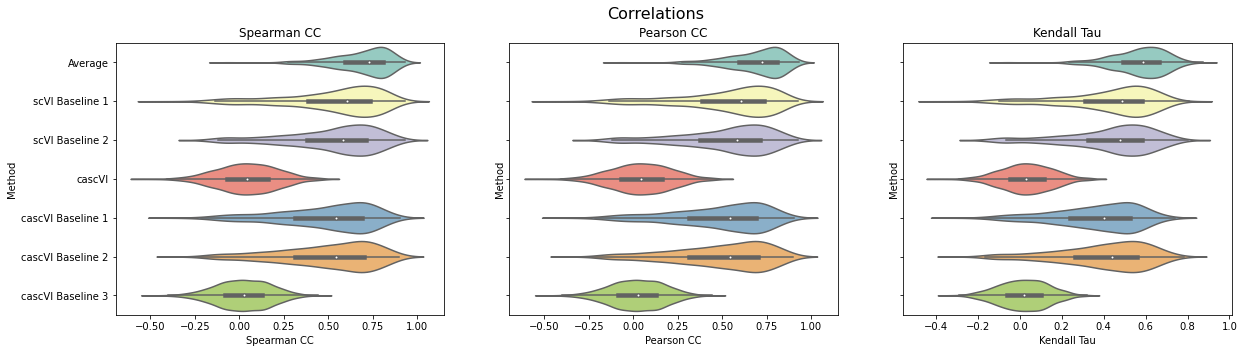

In [153]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, norm_cascvi_X_2, norm_cascvi_X_3]
df = correlations(data, 'rank', True)
df.head(5)
plt.show()

### III. Table Summary

In [154]:
columns = ["Method", "Spearman CC", "Pearson CC", "Kendall Tau"]
data = [df1, df2, df3, df4, df5]

tables = [[] for i in range(len(data))]

#task = ["Sample-Sample (None)", "Sample-Sample (CPM)", "Gene-Gene (None)", 
           #"Gene-Gene(CPM)", "Gene-Gene (Rank)" ]

for (df, t) in zip(data, tables):
    for m in np.unique(df.Method):
        sub_df = np.round(df[df['Method'] == m].mean(), decimals=3)
        t.append([m, sub_df['Spearman CC'], sub_df['Pearson CC'], sub_df['Pearson CC']])
        
# Create and style Data Frames
df_table1 = pd.DataFrame(tables[0], columns=columns)
df_table2 = pd.DataFrame(tables[1], columns=columns)
df_table3 = pd.DataFrame(tables[2], columns=columns)
df_table4 = pd.DataFrame(tables[3], columns=columns)
df_table5 = pd.DataFrame(tables[4], columns=columns)

In [155]:
print(" >>> Sample-Sample | No Normalization <<<")
df_table1.head(10)

 >>> Sample-Sample | No Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.791,0.737,0.737
1,cascVI,0.323,0.223,0.223
2,cascVI Baseline 1,0.608,0.554,0.554
3,cascVI Baseline 2,0.641,0.639,0.639
4,cascVI Baseline 3,0.340,0.226,0.226
5,scVI Baseline 1,0.714,0.693,0.693
6,scVI Baseline 2,0.660,0.582,0.582


In [ ]:
print(">>> Sample-Sample | CPM Normalization <<<")
df_table2.head(10)

In [ ]:
print(">>> Gene-Gene | No Normalization <<<")
df_table3.head(10)

In [ ]:
print(">>> Gene-Gene | CPM Normalization <<<")
df_table4.head(10)

In [ ]:
print(">>> Gene-Gene | Rank Normalization <<<")
df_table5.head(10)

# 8. Exploratory grapghical analysis

***Box plot (Samples)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 300), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[k]), np.log(1 + norm_imputed_X[k]),
          np.log(1 + norm_avg_X[k]), np.log(1 + norm_scvi_X[k]),
           np.log(1 + norm_cascvi_X[k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Sample ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Box plot (Genes)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 1000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[:, k]), np.log(1 + norm_imputed_X[:, k]),
          np.log(1 + norm_avg_X[:, k]), np.log(1 + norm_scvi_X[:, k]),
           np.log(1 + norm_cascvi_X[:, k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Density plots***

In [ ]:
import random
import seaborn as sns

n_samples = 12
idx = random.sample(range(1, 1000), n_samples)
n_rows = 3
n_cols = int(n_samples / n_rows)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(35, 15))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # density plots
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_imputed_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='cascVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_internal_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='groundtruth')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_scvi_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg scVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_avg_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_cascvi_X[:, k]), hist=False,
             kde=True, kde_kws={'shade': True}, label='Avg cascVI')
        # set title
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Combined gene density plots")
plt.show()